In [222]:
import numpy as np
from scipy.sparse.linalg import svds
import matplotlib.pyplot as plt
%matplotlib inline

### Load MNIST

In [2]:
from torchvision import datasets
data = datasets.MNIST('data', train=True, download=True)
X_numpy = data.train_data.numpy()/255
y_numpy = data.train_labels.numpy()

def draw_MNIST(image, label = ''):
    # Take a numpy array of 784 entries
    plt.imshow(image.reshape(28,28), cmap='gray')
    plt.title(label)
    plt.show()

def onehot(integer_labels):
    #Return matrix whose rows are onehot encodings of integers.
    onehotL = np.zeros((len(integer_labels), len(np.unique(integer_labels))), dtype='uint8')
    onehotL[np.arange(len(integer_labels)), integer_labels] = 1
    return onehotL

X_numpy = X_numpy.reshape(60000,-1)
y_numpy = onehot(y_numpy)
print(X_numpy.shape, y_numpy.shape)

(60000, 784) (60000, 10)


## Normalized Iterative Hard Thresholding (NIHT)
First implement NIHT [(Blumensath & Davies 2010)](https://ieeexplore.ieee.org/stamp/stamp.jsp?arnumber=5419091) for solving underdetermined linear system with sparse constraint:

$$
    \min_{x} \| Ax - y \|_2^2, \qquad \text{s.t.}\quad \|x\|_0\leq k, 
$$
where $A\in R^{m\times n}$, $x\in R^n$, and $y\in R^{m}$, (where $n>m>k$).

In [95]:
def thresh_hard_sparse(x, k):
    """
    Keep only k largest entries of x.
    Parameters
    ----------
    x : numpy array
        Numpy array to be thresholded
    k : int
        Number of largest entries in absolute value to keep
    Notes
    """
    _x = x.copy()
    ind = np.argpartition(abs(_x), -k, axis=None)[-k:]
    ind = np.unravel_index(ind, _x.shape)
    ind_del = np.ones(_x.shape, dtype=bool)
    ind_del[ind] = False
    _x[ind_del] = 0
    return ind, _x

def support_projection(x, ind):
    """
    Keeps only parameters at indices
    ----------
    x : numpy array
        Numpy array to be projected
    ind : int
        where to keep entries keep
    """
    _x = x.copy()
    ind_del = np.ones(x.shape, dtype=bool)
    ind_del[ind] = False
    _x[ind_del] = 0
    return x

In [206]:
def niht(A, y, k, tol = 1e-4, MAX_ITER = 100):
    """
    Normalized Iterative Hard Thresholding solving underdetermined
    Ax = b,
    Parameters
    ----------
    A : numpy array
        Underdetermined matrix
    y : numpy array
        Right-hand side vector
    k : int
        Sparsity constraint on x
    Notes
    """
    error = np.zeros(MAX_ITER)
    w = A.T.dot(y)
    T_k, x = thresh_hard_sparse(w, k)
    error[0] = np.linalg.norm(A.dot(x) - y)/np.linalg.norm(y)  
    # Iterative process
    l = 2
    not_finished = True
    while not_finished:
        r = A.T.dot(y-A.dot(x))
        r_proj = support_projection(r, T_k)
        a = np.linalg.norm(r_proj)**2
        b = np.linalg.norm(A.dot(r_proj))**2
        alpha = a/b
        w = x + alpha * r
        T_k, x = thresh_hard_sparse(w, k)
        error[l-1] = np.linalg.norm(A.dot(x) - y)/np.linalg.norm(y) 
        not_finished = (l < MAX_ITER) and (error[l-1] >= tol)
        l = l + 1
    return (x, error[:(l-1)])

### Test example

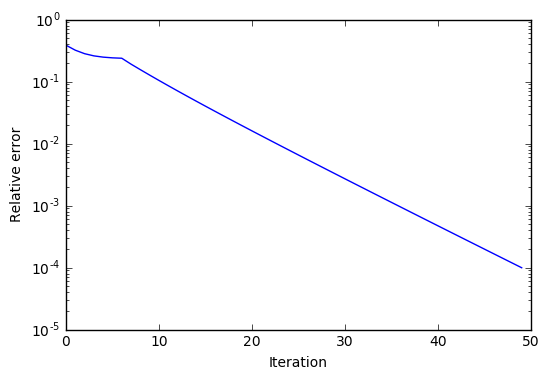

In [207]:
m = 200
n= 500
k = 10
x = np.random.randn(n, 1)
A = np.random.randn(m, n) / np.sqrt(m)
ind, x = thresh_hard_sparse(x, k)
y = np.matmul(A, x, out=None)
x, error = niht(A, y, k, tol = 1e-4, MAX_ITER = 100)
plt.plot(error)
plt.yscale('log')
plt.xlabel('Iteration')
plt.ylabel('Relative error')
plt.show()

## Implementing K-SVD
Basic implementation of K-SVD [Aharon, Elad, Bruckstein, 2006](https://sites.fas.harvard.edu/~cs278/papers/ksvd.pdf). Solve the following dictionary learning problem:

$$
    \min_{D,X} \| Y - DX \|_F^2, \qquad \text{s.t.} \quad \|x_i\|_0\leq T,
$$
where $Y\in R^{n\times N}$, $D\in R^{n\times K}$, $X\in R^{K\times N}$, with $N>n>K$.
- $N$ is number of samples,
- $n$ is dimension of each sample,
- $K$ is number of all dictionary elements we wish to recover,
- $T$ is how many dictionary elements are allowed to be used to approximate every sample.

In [540]:
def ksvd(Y,K,T, tol = 1e-4, MAX_ITER = 100):
    """
    Naive implementation of K-SVD, solving
    Y \approx D X,
    Parameters
    ----------
    Y : numpy array
        Matrix of data samples
    K : int
        Number of dictionary elements
    T : int
        Sparsity constraint on how many dictionary elements to be used for every sample
    Notes
    """
    error = np.zeros(MAX_ITER)
    # Get sizes of the problem
    n, N = Y.shape
    # Gaussian random initialization for D
    # D = np.random.randn(n, K) / np.sqrt(n)
    # Initialize dictionary with data
    D =  Y[:,:K] / np.linalg.norm(Y[:,:K], axis=0)
    X = np.zeros((K,N))
    # Iterative process
    J = 1
    not_finished = True
    while not_finished:
        # Sparse Coding Stage
        for i in range(N):
            #print(D.shape, Y[:,i].shape, Y.shape)
            x_tmp,_ = niht(D, Y[:,i], T, tol = 1e-7, MAX_ITER = 80)
            X[:,i] = x_tmp
            
        error[J-1] = np.linalg.norm(Y - D @ X, ord='fro')/np.linalg.norm(Y, ord='fro')
        # Codebook Update Stage
        for k in range(K):
            w_k = np.where(X[k] == 0)[0]
            ind = np.ones((K,), bool)
            ind[k] = False
            E_k = Y - D[:,ind] @ X[ind,:]
            u, s, vt = svds(E_k[:,w_k], k = 1)
            D[:,k] = u.T
            X[k,w_k] = s[0] * vt
        not_finished = (J < MAX_ITER) and (error[J-1] >= tol)
        print(error[J-1])
        J = J + 1
    return (D,X,error)

### Test on MNIST

In [ ]:
N = 2*28**2
Y = X_numpy[:N].T
D, X, error = ksvd(Y, K = 2*28**2, T = 25, MAX_ITER = 10)

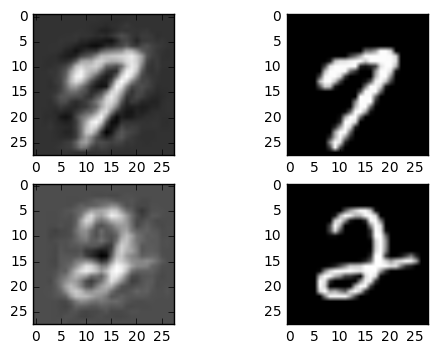

In [521]:
sample_id = 15
plt.subplot(2, 2, 1)
plt.imshow((D@X)[:,sample_id].reshape(28,28), cmap='gray')
plt.subplot(2, 2, 2)
plt.imshow(Y[:,sample_id].reshape(28,28), cmap='gray')

sample_id = 16
plt.subplot(2, 2, 3)
plt.imshow((D@X)[:,sample_id].reshape(28,28), cmap='gray')
plt.subplot(2, 2, 4)
plt.imshow(Y[:,sample_id].reshape(28,28), cmap='gray')
plt.show()

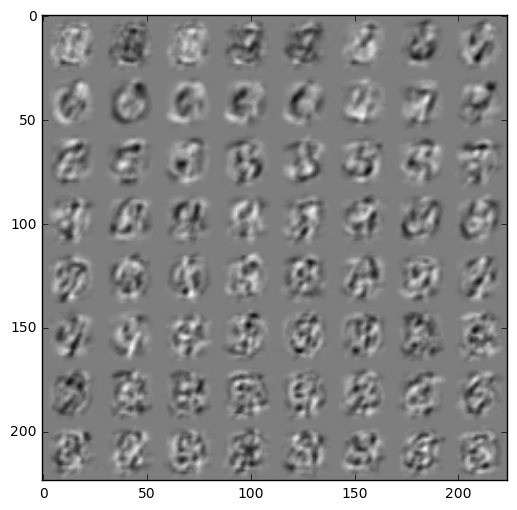

In [519]:
D_tmp = D.reshape(28,28,8,8)
D_tmp = np.moveaxis(D_tmp, 2, 0)
D_tmp = np.moveaxis(D_tmp, 3, 2)
D_tmp = D_tmp.reshape(28*8, 28*8)
plt.figure(num=None, figsize=(8, 6), dpi=200, facecolor='w', edgecolor='k')
plt.imshow(D_tmp, cmap = 'gray')
plt.show()